In [1]:
import os
import pandas as pd
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

from vgg16_odd_utils import OpticDiscDataset, train_test_val_split

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

<img src="vgg-16.png" width=500 height=300 /> <img src="vgg16-odd-architecture.png"/><br><br>
<br><br> **VGG-16 architecture**

# Model

In [2]:
class UnetVGG16(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        ''' in_channels = 3 '''
        
        self.conv1 = self.contract_block(in_channels, 64, 7, 3)  # L1, L2, P1
        self.conv2 = self.contract_block(64, 128, 3, 1)  # L3, L4, P2
        self.conv3 = self.contract_block(128, 256, 3, 1) # L5, L6, P3
        self.conv4 = self.contract_block(256, 512, 3, 1) # L7, L8, P4

        self.upconv4 = self.expand_block(512, 256, 3, 1) 
        self.upconv3 = self.expand_block(256*2, 128, 3, 1) #
        self.upconv2 = self.expand_block(128*2, 64, 3, 1)
        self.upconv1 = self.expand_block(64*2, out_channels, 3, 1)


    def __call__(self, dataset):

        conv1 = self.conv1(dataset)  # downsampling
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        
        upconv4 = self.upconv4(conv4)   # upsampling
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1


    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        ''' Contracting blocks '''
        contract = nn.Sequential(
            nn.Conv2d(
                in_channels, 
                out_channels, 
                kernel_size=kernel_size, 
                stride=1, 
                padding=padding),  # O = n-k+1 = 256-7+1 = 250
            nn.BatchNorm2d(out_channels), # (X-mean)/stdev for all features x samples, ensures all feature values are on the same scale.
            nn.ReLU(),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=padding),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3,
                stride=2,
                padding=1)
        )
        return contract


    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        ''' Expanding blocks '''
        expand = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride=1,
                padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size,
                stride=1,
                padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(
                out_channels,
                out_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1)
        )
        return expand


def train(
    model,
    train_loader, val_loader,
    loss_fn, optimizer, acc_fn, epochs=1):
    
    tic = time.time()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    train_loss, val_loss = [], []
    best_acc = 0.0


    for epoch in range(epochs):

        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)   # train model
                data_loader = train_loader
            else:
                model.train(False)
                data_loader = val_loader
            
            running_loss = 0.0
            running_acc = 0.0

            step = 0

            for x, y in data_loader:
                x = x.to(device)
                y = y.to(device)
                y = torch.squeeze(y)
                y = y.type(torch.LongTensor)    # Long = 64-bit integer
                step += 1

                # forward pass:
                if phase == 'train':
                    optimizer.zero_grad()  # zero the gradients
                    outputs = model(x)
                    loss = loss_fn(outputs, y)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y)
                
                acc = acc_fn(outputs, y)

                running_acc += acc * data_loader.batch_size
                running_loss += loss * data_loader.batch_size
                
                # for every 10th step
                if step % 10 == 0:
                    print('Current step: {}   | Loss: {:.4f}    | Accuracy: {:.4f}      AllocMem (Mb): {}   '.format(
                        step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
            
            epoch_loss = running_loss/len(data_loader.dataset)
            epoch_acc = running_acc/len(data_loader.dataset)

            print('Current epoch: {}   | Loss: {}    | Accuracy: {} '.format(phase.upper(), epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else val_loss.append(epoch_loss)    # append epoch loss to train or val. 
        
    toc = time.time() - tic

    print('Training complete in {:.0f}m {:.0f}s'.format(toc//60, toc%60))

    return train_loss, val_loss


def acc_metric(pred, y):
    return (pred.argmax(dim=1)==y).float().mean()


# Load and build Tensor Dataset

In [13]:
DATA = '../data/mdai-odd/'
IMAGE = 'image'
MASK  = 'mask'

IMAGE_PATH = os.path.join(DATA, IMAGE)
MASK_PATH = os.path.join(DATA, MASK)

id_map = pd.read_csv(os.path.join(DATA, 'id_map.csv'))
id_map = id_map[['id', 'Slice_ODD_id', 'labelName']]

print('IMAGE_PATH: %s' % IMAGE_PATH)
print('MASK_PATH: %s' % MASK_PATH)
print(' --- ')
display(id_map.head())
print(' --- ')
print('Total images: ', id_map.id.nunique())
print(' --- ')
for label_name in id_map['labelName'].unique():
    print('Number of %s: %d' % (
        label_name, id_map[id_map['labelName']==label_name]['id'].nunique()))
print(' --- ')

# Let's try only using Drusen images for now?
id_map = id_map[id_map.labelName=='Drusen']
train_id, test_id, val_id = train_test_val_split(id_map['id'].values.tolist())

IMAGE_PATH: ../data/mdai-odd/image
MASK_PATH: ../data/mdai-odd/mask
 --- 


,id,Slice_ODD_id,labelName
0,A_Km5eJK,56_ODD-245_OS,Drusen
1,A_K0a9yV,56_ODD-245_OS,Drusen
2,A_VovNDK,56_ODD-245_OS,Drusen
3,A_gjq2PL,40_ODD-245_OS,Drusen
4,A_KAkM1L,37_ODD-245_OS,Drusen


 --- 
Total images:  1754
 --- 
Number of Drusen: 509
Number of Blood vessel: 398
Number of Hyperreflective Line: 847
 --- 
train_id  : 0.60, 305 images
test_id   : 0.20, 102 images
val_id    : 0.20, 102 images


In [14]:
# Preprocess at this stage is simple, make into tensor and resize

# How many numbers of samples processed before the model is updated
batch_size = 20

# Number of complete passes through the training dataset
epochs = 5

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
    ])  # ToTensor first!

train_set = OpticDiscDataset(
    IMAGE_PATH, MASK_PATH, train_id, transform=preprocess, target_transform=preprocess)

test_set = OpticDiscDataset(
    IMAGE_PATH, MASK_PATH, test_id, transform=preprocess, target_transform=preprocess)

val_set = OpticDiscDataset(
    IMAGE_PATH, MASK_PATH, val_id, transform=preprocess, target_transform=preprocess)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

train_x, train_y = next(iter(train_loader))
val_x, val_y = next(iter(val_loader))

print(train_x.shape, train_y.shape)

torch.Size([20, 3, 256, 256]) torch.Size([20, 1, 256, 256])


0.00762939453125


65536

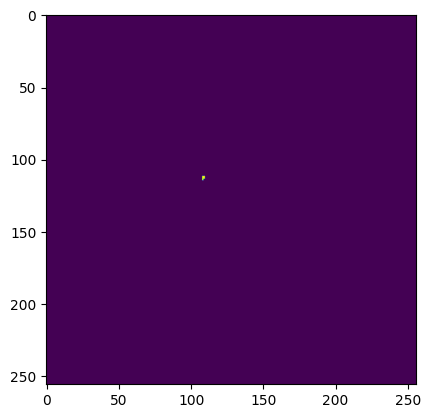

In [27]:
test = train_y[1,0,:,:].numpy()
test = np.where(test!=0,1,0)
plt.imshow(test)

istarget = (test.sum() / test.size) * 100
print(istarget)
np.unique(test)

test.size

import glob
for fname in glob.glob(MASK_PATH):
    pass

In [5]:
model = UnetVGG16(3,3)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.01)
train_loss, val_loss = train(model, train_loader, val_loader, loss_fn, optimizer, acc_metric, epochs=epochs)

torch.save(model, 'unetvgg16_12162022.h5')

Epoch 1/5
----------
Current step: 10   | Loss: 0.5667    | Accuracy: 0.9964      AllocMem (Mb): 0.0   
Current epoch: TRAIN   | Loss: 0.6949271559715271    | Accuracy: 1.0061063766479492 
Current epoch: VALID   | Loss: 0.322151780128479    | Accuracy: 1.1719614267349243 
Epoch 2/5
----------
Current step: 10   | Loss: 0.1940    | Accuracy: 0.9964      AllocMem (Mb): 0.0   
Current epoch: TRAIN   | Loss: 0.23568375408649445    | Accuracy: 1.0446199178695679 
Current epoch: VALID   | Loss: 0.14283928275108337    | Accuracy: 1.1723519563674927 
Epoch 3/5
----------
Current step: 10   | Loss: 0.1219    | Accuracy: 0.9963      AllocMem (Mb): 0.0   
Current epoch: TRAIN   | Loss: 0.13633078336715698    | Accuracy: 1.0445235967636108 
Current epoch: VALID   | Loss: 0.102935791015625    | Accuracy: 1.17158043384552 
Epoch 4/5
----------
Current step: 10   | Loss: 0.0972    | Accuracy: 0.9961      AllocMem (Mb): 0.0   
Current epoch: TRAIN   | Loss: 0.10658671706914902    | Accuracy: 1.0443335

Plot loss function

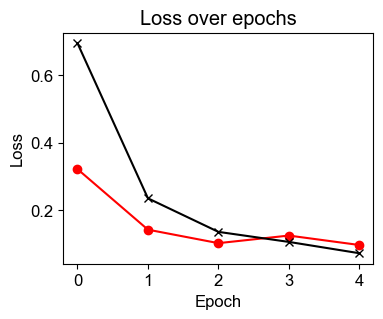

In [6]:
train_loss_npy = [tl.detach().numpy() for tl in train_loss]
val_loss_npy = [tl.detach().numpy() for tl in val_loss]

matplotlib.rcParams["font.family"]      = "sans-serif"
matplotlib.rcParams["font.sans-serif"]  = "Arial"
matplotlib.rcParams["font.size"]        = 12

plt.figure(figsize=(4,3))
plt.plot(val_loss_npy, '-o', c='r')
plt.plot(train_loss_npy, '-x', c='k')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

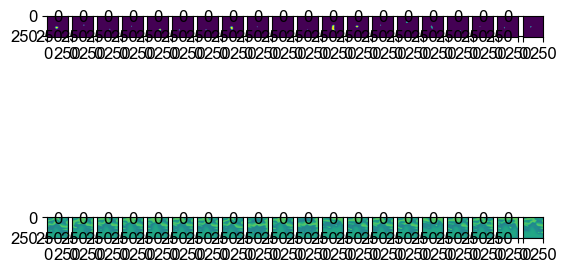

In [7]:
# Test out model?
channel = 0

test_x, test_y = next(iter(test_loader))    
# Just the first, there are 6

f, ax = plt.subplots(2, batch_size, figsize=(20,4))

for batch in range(batch_size):
    with torch.no_grad():
        outputs = model(test_x) # batch_size, n_channels, 256, 256
        test_img = torch.squeeze(test_y[batch,0,:,:])
        pred_img = torch.squeeze(outputs[batch,0,:,:])
        c = batch #% batch_size
        ax[0,c].imshow(test_img)
        ax[1,c].imshow(pred_img)

plt.show()

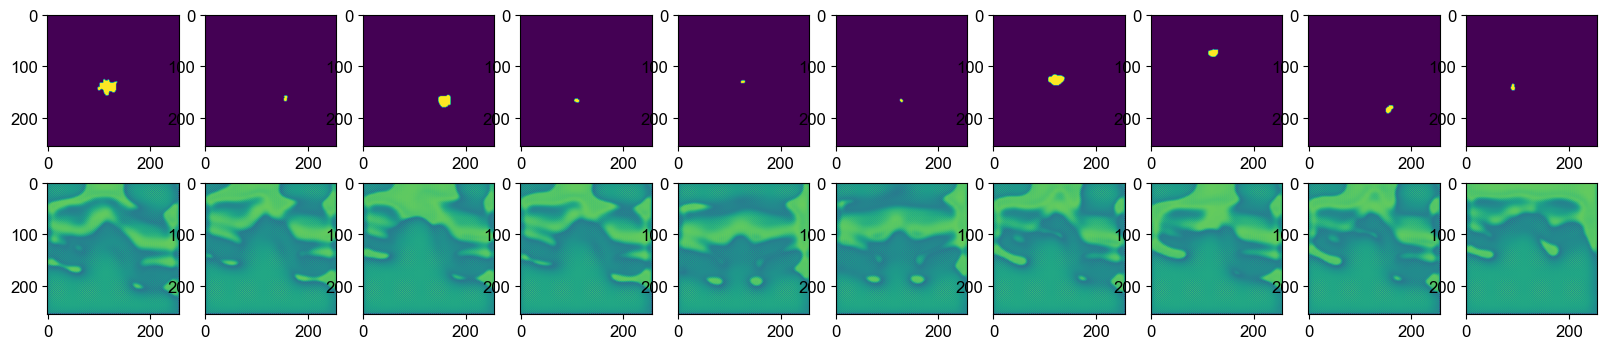

In [17]:
f, ax = plt.subplots(2, 10, figsize=(20,4))
for i, batch in enumerate(np.arange(0,batch_size,2)):
    with torch.no_grad():
        outputs = model(test_x) # batch_size, n_channels, 256, 256
        test_img = torch.squeeze(test_y[batch,0,:,:])
        pred_img = torch.squeeze(outputs[batch,0,:,:])
        ax[0,i].imshow(test_img)
        ax[1,i].imshow(pred_img)
plt.tight_layout()
plt.show()

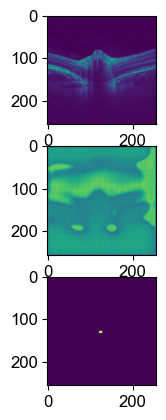

In [36]:
f, ax = plt.subplots(3,1,)
batch = 8

diff = test_x[batch,0,:,:] - outputs[batch,0,:,:]
ax[0].imshow(test_x[batch,0,:,:])
ax[1].imshow(outputs[batch,0,:,:])
ax[2].imshow(test_y[batch,0,:,:])




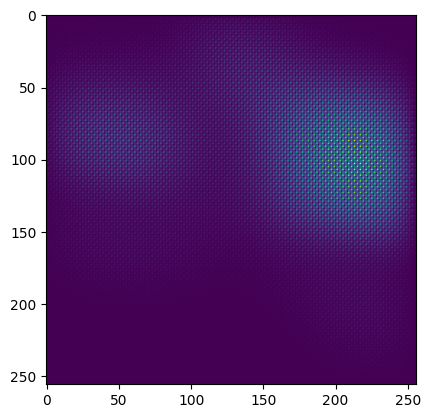

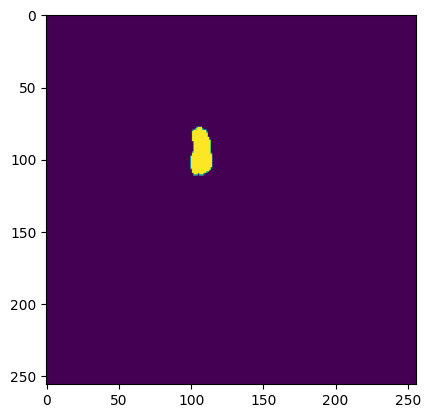

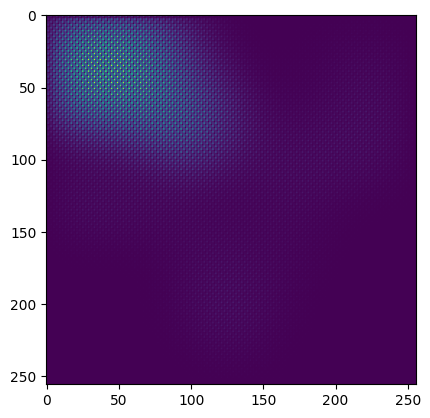

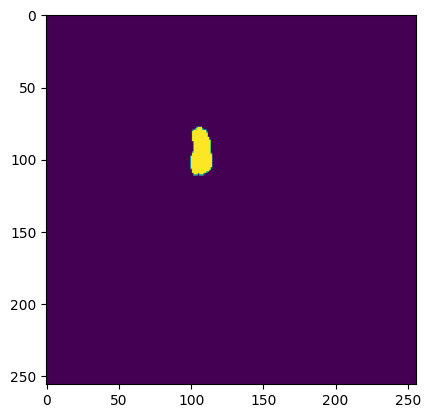

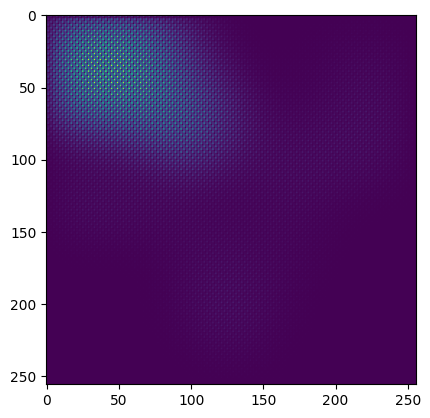

In [65]:
plt.imshow(torch.squeeze(test_y[0,0,:,:]))
plt.imshow(torch.squeeze(outputs[0,0,:,:]))

for b in range(2):
    plt.figure()
    plt.imshow(torch.squeeze(test_y[0,0,:,:]))
    plt.figure()
    plt.imshow(torch.squeeze(outputs[0,0,:,:]))

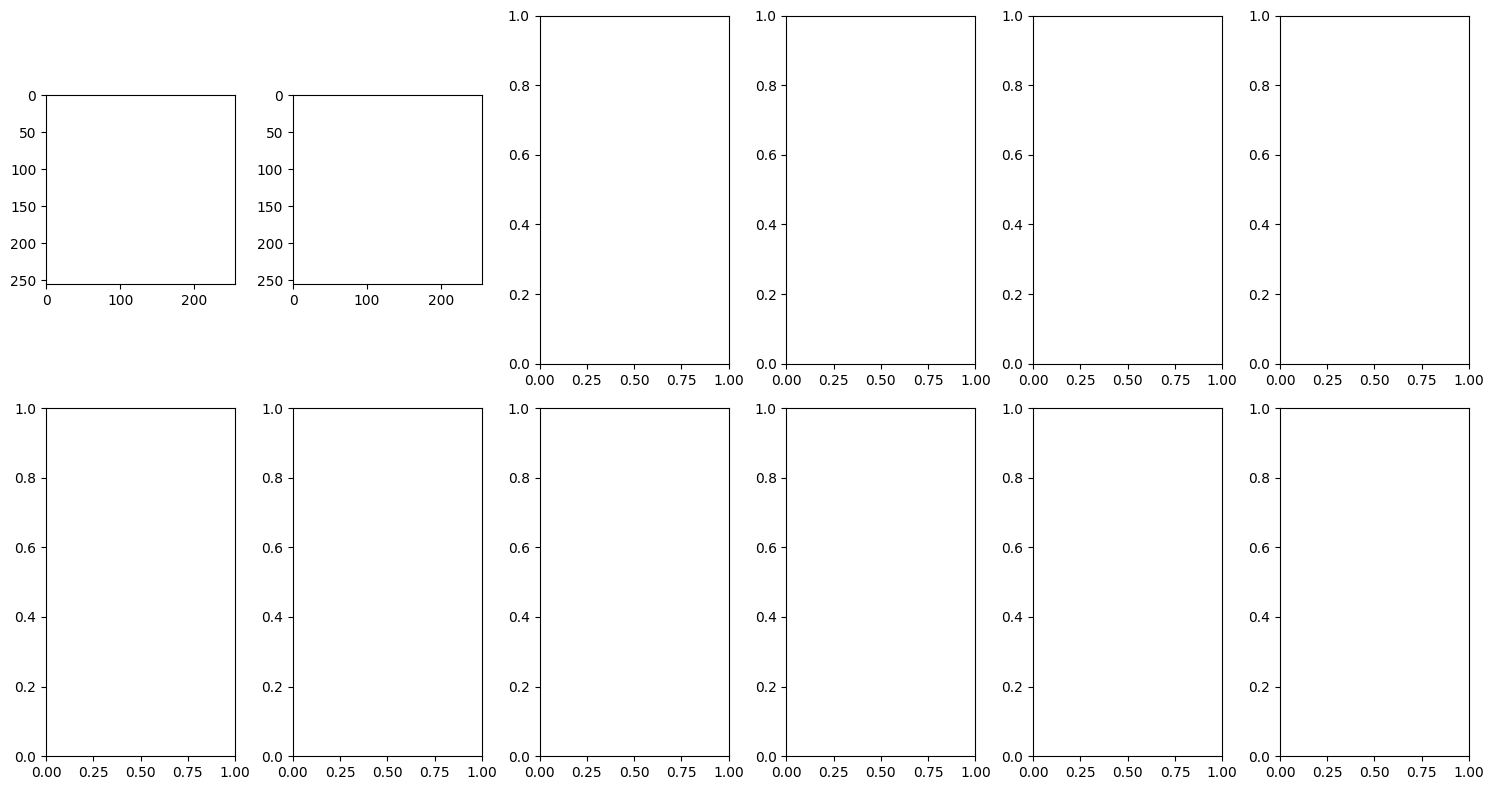

In [49]:
def squeeze_classes(t):
    n_imgs = t.shape[0]
    class_dim = t.shape[1]  # second dimension
    img_dim = t.shape[2]
    t_output = np.zeros((n_imgs, img_dim, img_dim))
    for batch in range(n_imgs):
        #for dim in range(class_dim):
        t_squeeze = torch.squeeze(t[batch,:,:,:]).numpy()
        t_max = t_squeeze.min(axis=0)
        t_reshape = t_max.reshape(img_dim,img_dim)
        t_output[batch,:,:] = t_reshape
    return t_output

#p_out = squeeze_classes(pred_y)

ncols = 6
f,ax = plt.subplots(2,ncols, figsize=(15,8))
for i in range(pred_y.shape[0]):
    r,c = i//ncols, i%ncols
    im = ax[r,c].imshow(np.squeeze(pred_y.numpy()[i,:,:]), cmap='binary')
#plt.colorbar(im, ax=ax.ravel().tolist())
plt.tight_layout()
